In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import datetime
import re
import warnings
from datetime import datetime
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats as stats
import sklearn.linear_model as linear_model
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'


warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
#reducing the memory usage before using the dataframes for plotting and modelling
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_weather = pd.read_csv('homeC2015.csv')
df_meter = pd.read_csv('HomeC-meter1_2015.csv', parse_dates=[0], index_col=[0])

In [ ]:
df_weather = reduce_mem_usage(df_weather)
df_meter = reduce_mem_usage(df_meter)

In [4]:
df_weather.shape

(8760, 14)

In [5]:
df_meter.shape

(39764, 18)

In [6]:
df_meter.head()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
Date & Time,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,1.167223,0.0,1.167223,0.000236,0.229379,0.331326,0.018590,0.067467,0.004420,0.009904,0.000437,0.000060,0.000007,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:30:00,1.171444,0.0,1.171444,0.000225,0.228758,0.300048,0.018604,0.108881,0.004456,0.010001,0.000347,0.000087,0.000007,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,1.151474,0.0,1.151474,0.000229,0.229446,0.323099,0.018620,0.005851,0.004449,0.009916,0.000612,0.000031,0.000007,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:30:00,1.398982,0.0,1.398982,0.000209,0.277066,0.314399,0.018593,0.005925,0.004457,0.009872,0.000693,0.000004,0.000007,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,1.080775,0.0,1.080775,0.000239,0.228736,0.308560,0.018638,0.062217,0.004478,0.010046,0.000497,0.000032,0.000006,0.0,0.0,0.0,0.0,0.0


In [6]:
df_meter_half_hourly = df_meter.loc['2015-01-01 00:00:00':'16-12-2015 00:00:00']

In [7]:
df_meter_half_hourly.shape

(16753, 18)

In [8]:
df_meter_half_minute = df_meter.loc['12-16-2015 00:29:00':'12-31-2015 23:59:00']

In [9]:
df_meter_half_minute.shape

(23011, 18)

In [10]:
df_meter_half_minute = df_meter_half_minute.resample('30min').mean()

In [11]:
df_meter_half_minute.shape

(768, 18)

In [13]:
df_meter_half_minute.head()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
Date & Time,,,,,,,,,,,,,,,,,,
2015-12-16 00:00:00,0.332600,0.003450,0.332600,0.000000,0.020550,0.062917,0.076150,0.005100,0.007950,0.013100,0.000733,0.000017,0.000000,0.031267,0.001000,0.004250,0.001567,0.003450
2015-12-16 00:30:00,0.448696,0.003472,0.448696,0.000045,0.105328,0.063216,0.076371,0.005099,0.007912,0.013007,0.000734,0.000091,0.000011,0.031313,0.001014,0.004185,0.001594,0.003472
2015-12-16 01:00:00,0.634005,0.003455,0.634005,0.000051,0.125489,0.179347,0.074915,0.051913,0.007959,0.013087,0.000617,0.000094,0.000009,0.036627,0.001017,0.004249,0.001628,0.003455
2015-12-16 01:30:00,0.637458,0.003461,0.637458,0.000033,0.094766,0.194724,0.062693,0.074023,0.007978,0.013170,0.000562,0.000105,0.000008,0.036904,0.001012,0.004259,0.001631,0.003461
2015-12-16 02:00:00,0.642636,0.003487,0.642636,0.000034,0.132943,0.210009,0.064124,0.005186,0.007972,0.013173,0.000722,0.000065,0.000007,0.036484,0.001023,0.004198,0.001621,0.003487


In [14]:
df_meter_half_minute.index[0]

Timestamp('2015-12-16 00:00:00', freq='30T')

In [12]:
df_meter_half_minute = df_meter_half_minute.drop(df_meter_half_minute.index[0])

In [16]:
df_meter_half_minute.head()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
Date & Time,,,,,,,,,,,,,,,,,,
2015-12-16 00:30:00,0.448696,0.003472,0.448696,0.000045,0.105328,0.063216,0.076371,0.005099,0.007912,0.013007,0.000734,0.000091,0.000011,0.031313,0.001014,0.004185,0.001594,0.003472
2015-12-16 01:00:00,0.634005,0.003455,0.634005,0.000051,0.125489,0.179347,0.074915,0.051913,0.007959,0.013087,0.000617,0.000094,0.000009,0.036627,0.001017,0.004249,0.001628,0.003455
2015-12-16 01:30:00,0.637458,0.003461,0.637458,0.000033,0.094766,0.194724,0.062693,0.074023,0.007978,0.013170,0.000562,0.000105,0.000008,0.036904,0.001012,0.004259,0.001631,0.003461
2015-12-16 02:00:00,0.642636,0.003487,0.642636,0.000034,0.132943,0.210009,0.064124,0.005186,0.007972,0.013173,0.000722,0.000065,0.000007,0.036484,0.001023,0.004198,0.001621,0.003487
2015-12-16 02:30:00,0.625756,0.003463,0.625756,0.000067,0.114166,0.216405,0.062718,0.032830,0.008022,0.013228,0.000671,0.000152,0.000009,0.031778,0.001007,0.004268,0.001601,0.003463


In [17]:
df_meter_half_hourly.tail()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW]
Date & Time,,,,,,,,,,,,,,,,,,
2015-12-15 22:00:00,1.257293,0.003193,1.257293,0.000020,0.066612,0.062948,0.124074,0.101980,0.126054,0.022908,0.017120,8.611100e-05,0.000012,0.036223,0.001046,0.004379,0.322414,0.003193
2015-12-15 22:30:00,1.302146,0.002732,1.302146,0.000009,0.020520,0.063111,0.154532,0.054410,0.037740,0.013071,0.037535,7.055600e-05,0.000009,0.030549,0.001101,0.004724,0.329678,0.002732
2015-12-15 23:00:00,1.012101,0.002886,1.012101,0.000006,0.020596,0.063120,0.145565,0.011709,0.007866,0.013130,0.000599,1.444440e-04,0.000011,0.035489,0.001113,0.004590,0.212629,0.002886
2015-12-15 23:30:00,0.486768,0.003415,0.486768,0.000001,0.020586,0.063312,0.098642,0.074648,0.007931,0.013127,0.000564,5.560000e-07,0.000007,0.031084,0.001014,0.004284,0.001538,0.003415
2015-12-16 00:00:00,0.482859,0.003457,0.482859,0.000032,0.091849,0.063606,0.083810,0.059764,0.007941,0.013033,0.000611,4.310300e-05,0.000006,0.031110,0.001011,0.004251,0.001616,0.003457


In [13]:
df_meter_half_hourly = df_meter_half_hourly.append(df_meter_half_minute)

In [14]:
df_meter_half_hourly.shape

(17520, 18)

In [14]:
df_meter = df_meter_half_hourly

In [15]:
df_meter = df_meter.drop(['gen [kW]', 'House overall [kW]'], axis=1)

In [16]:
df_meter = df_meter.resample('H').mean()

In [17]:
df_meter.shape

(8760, 16)

In [24]:
df_weather.head()

,temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,time,windBearing,precipIntensity,dewPoint,precipProbability
0,13.56,clear-night,0.73,10.00,Clear,4.58,1019.74,5.71,0.01,1420088400,227.0,0.0,6.48,0.0
1,14.69,clear-night,0.70,10.00,Clear,5.95,1018.68,5.69,0.05,1420092000,197.0,0.0,6.58,0.0
2,16.95,clear-night,0.66,9.90,Clear,9.10,1018.24,5.26,0.09,1420095600,205.0,0.0,7.54,0.0
3,18.29,clear-night,0.61,9.86,Clear,8.82,1017.67,7.18,0.08,1420099200,215.0,0.0,6.98,0.0
4,18.00,clear-night,0.59,9.88,Clear,7.94,1017.15,7.82,0.06,1420102800,225.0,0.0,6.16,0.0


# Data Preprocessing and EDA
**Weather data exists from Jan 1, 2015 to Dec 31, 2015 on an hourly basis. Meter data exists from Jan 1, 2015 to Dec 16, 2015 00:00 AM on half-hourly basis. Meter data is missing from 0:01 AM to 0:28 AM. After that, its available till Dec 31, 2015 on a per minute basis. Icon and Summary columns from weather data are useless and hence discarded. gen [kW] and House overall [kW] columns from Meter data either contain repeated data or no data at all and hence discarded. Also, weather data is converted to EST and both dataframes are indexed on date and time column. To combine both the data into a single dataframe, the meter dataframe is resampled on hourly basis and then both of them are merged to get a combined dataframe.**

In [18]:
df_weather = df_weather.drop(['icon', 'summary'], axis=1)
df_weather['Date & Time'] = pd.to_datetime(df_weather['time'], unit='s')
df_weather['Date & Time'] = df_weather['Date & Time'] - pd.Timedelta(hours=5)
df_weather.index = df_weather['Date & Time']
df_weather = df_weather.drop(['Date & Time', 'time'], axis=1)

In [26]:
df_weather.head()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
Date & Time,,,,,,,,,,,
2015-01-01 00:00:00,13.56,0.73,10.00,4.58,1019.74,5.71,0.01,227.0,0.0,6.48,0.0
2015-01-01 01:00:00,14.69,0.70,10.00,5.95,1018.68,5.69,0.05,197.0,0.0,6.58,0.0
2015-01-01 02:00:00,16.95,0.66,9.90,9.10,1018.24,5.26,0.09,205.0,0.0,7.54,0.0
2015-01-01 03:00:00,18.29,0.61,9.86,8.82,1017.67,7.18,0.08,215.0,0.0,6.98,0.0
2015-01-01 04:00:00,18.00,0.59,9.88,7.94,1017.15,7.82,0.06,225.0,0.0,6.16,0.0


In [19]:
df_meter_hourly = df_meter
df_weather_hourly = df_weather
df_meter_daily = df_meter_hourly.resample('D').mean()
df_weather_daily = df_weather_hourly.resample('D').mean()

In [20]:
comb_df_hourly = pd.merge(df_meter_hourly, df_weather_hourly, left_index=True, right_index =True, how='left')
comb_df_daily = pd.merge(df_meter_daily, df_weather_daily, left_index=True, right_index =True, how='left')

In [21]:
comb_df_hourly.shape

(8760, 27)

In [22]:
comb_df_daily.shape

(365, 27)

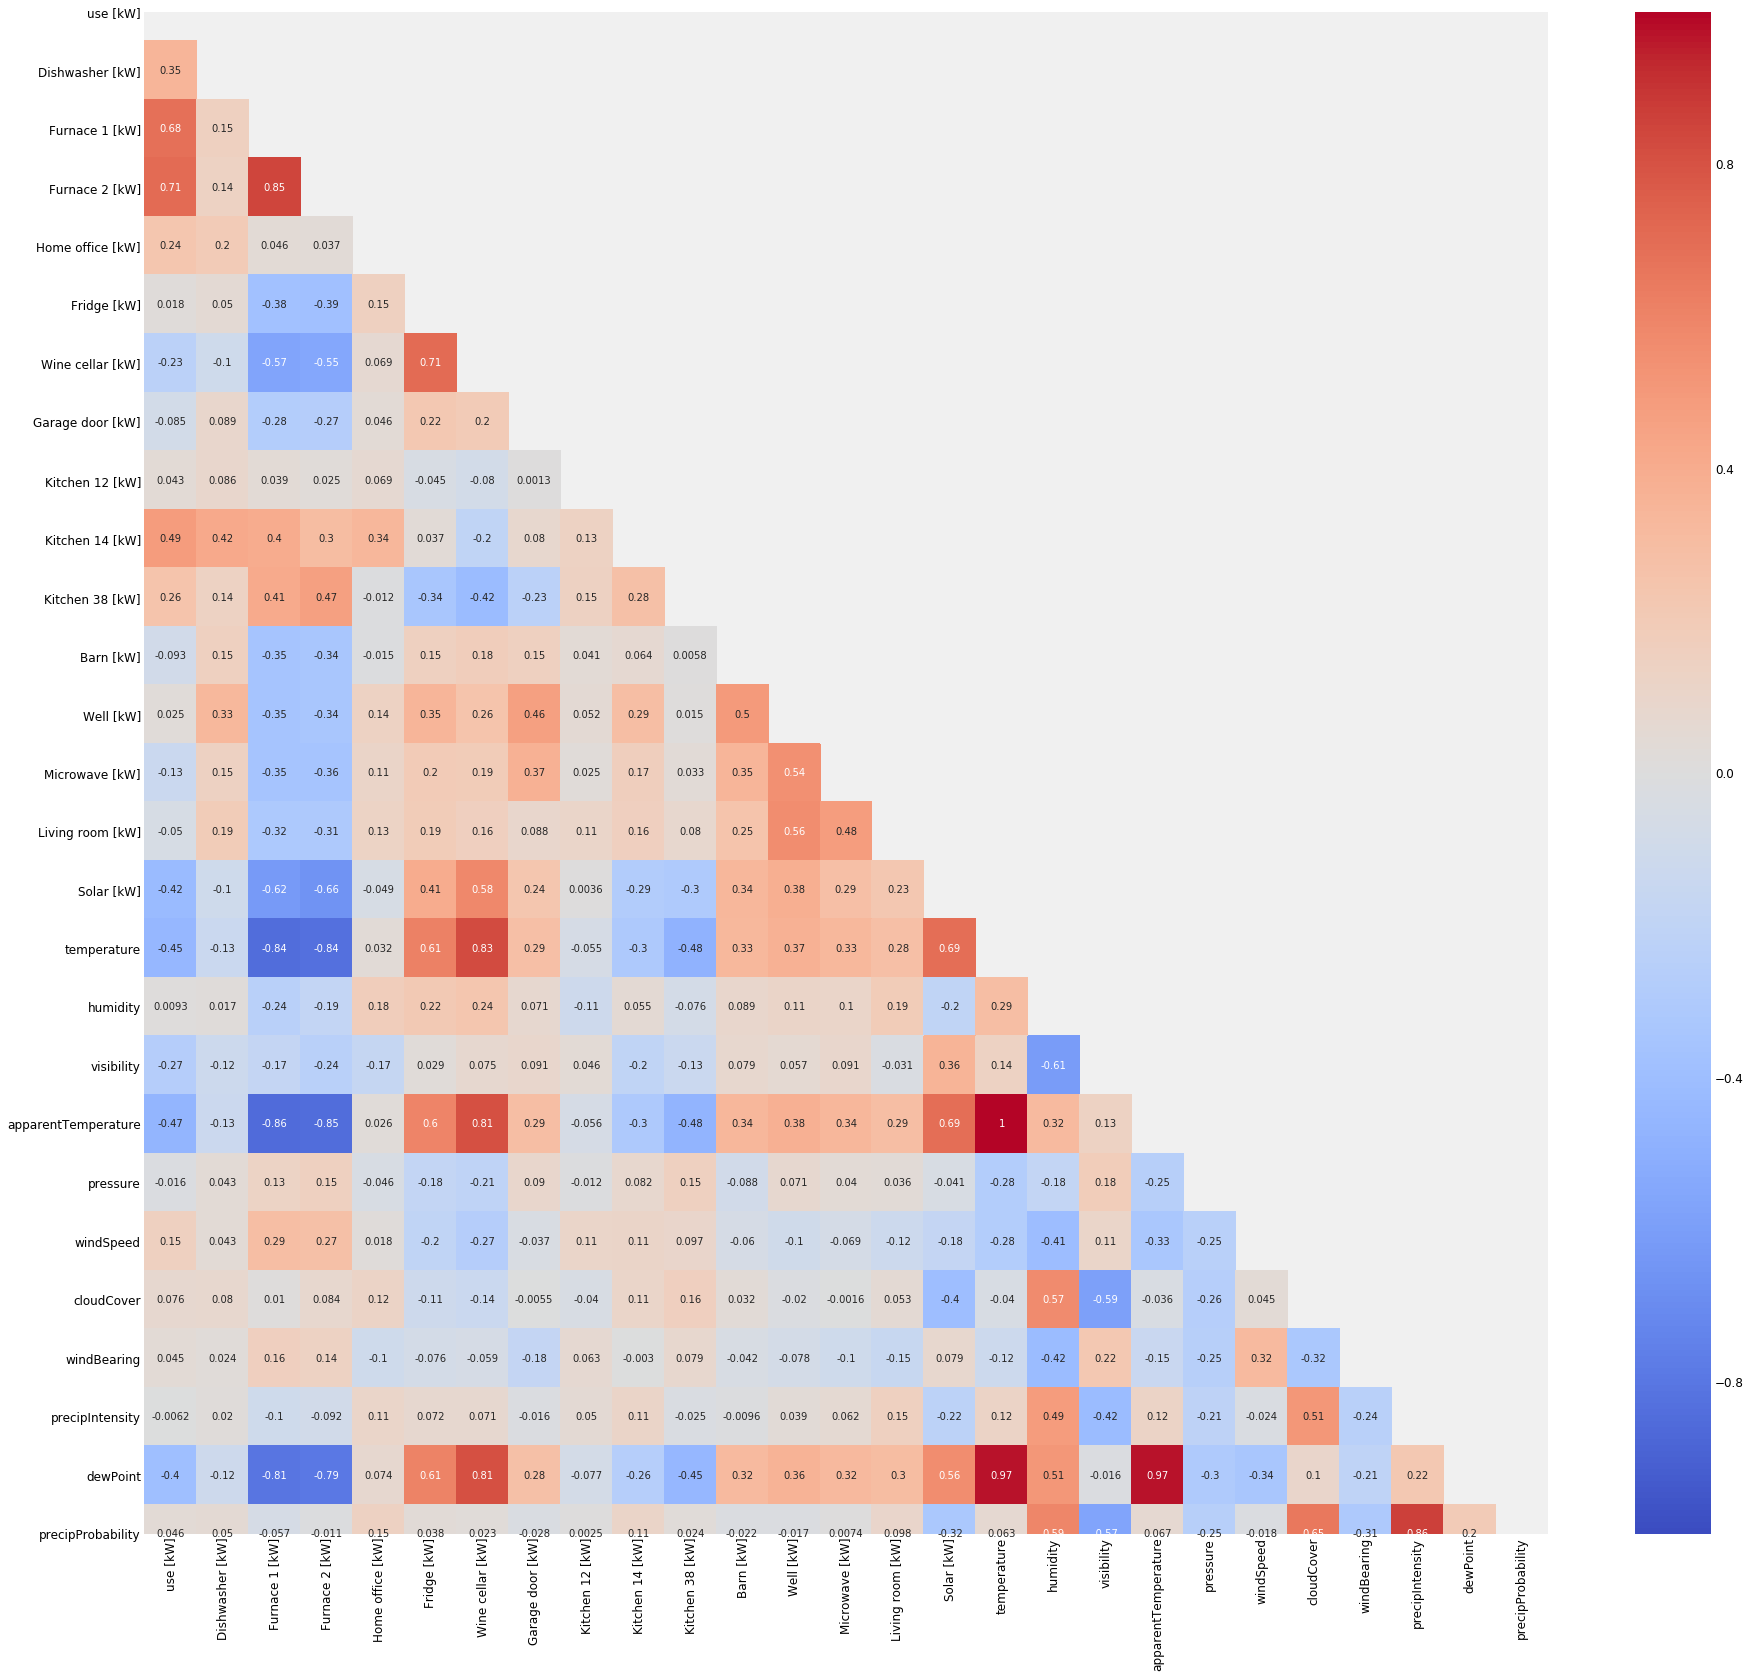

In [31]:
corr = comb_df_daily.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(28,28))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, mask = mask, vmin=-1)

In [23]:
#dropping apparentTemperature as it almost conveys the same info as temperature. precipProbability has very high correlation with precipIntensity
#and hence dropped
comb_df_daily = comb_df_daily.drop(['apparentTemperature', 'precipProbability'], axis=1)

In [24]:
#taking log for pressure values
comb_df_daily['pressure'] = comb_df_daily['pressure'].apply(np.log)

def remove_braces(df):
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns]
    return df

#remving braces from feature names as XGBoost doesn't allow braces
comb_df_daily = remove_braces(comb_df_daily)

In [25]:
comb_df_daily.shape

(365, 25)

In [35]:
comb_df_daily.isna().sum()

use _kW_            0
Dishwasher _kW_     0
Furnace 1 _kW_      0
Furnace 2 _kW_      0
Home office _kW_    0
Fridge _kW_         0
Wine cellar _kW_    0
Garage door _kW_    0
Kitchen 12 _kW_     0
Kitchen 14 _kW_     0
Kitchen 38 _kW_     0
Barn _kW_           0
Well _kW_           0
Microwave _kW_      0
Living room _kW_    0
Solar _kW_          0
temperature         0
humidity            0
visibility          0
pressure            0
windSpeed           0
cloudCover          0
windBearing         0
precipIntensity     0
dewPoint            0
dtype: int64

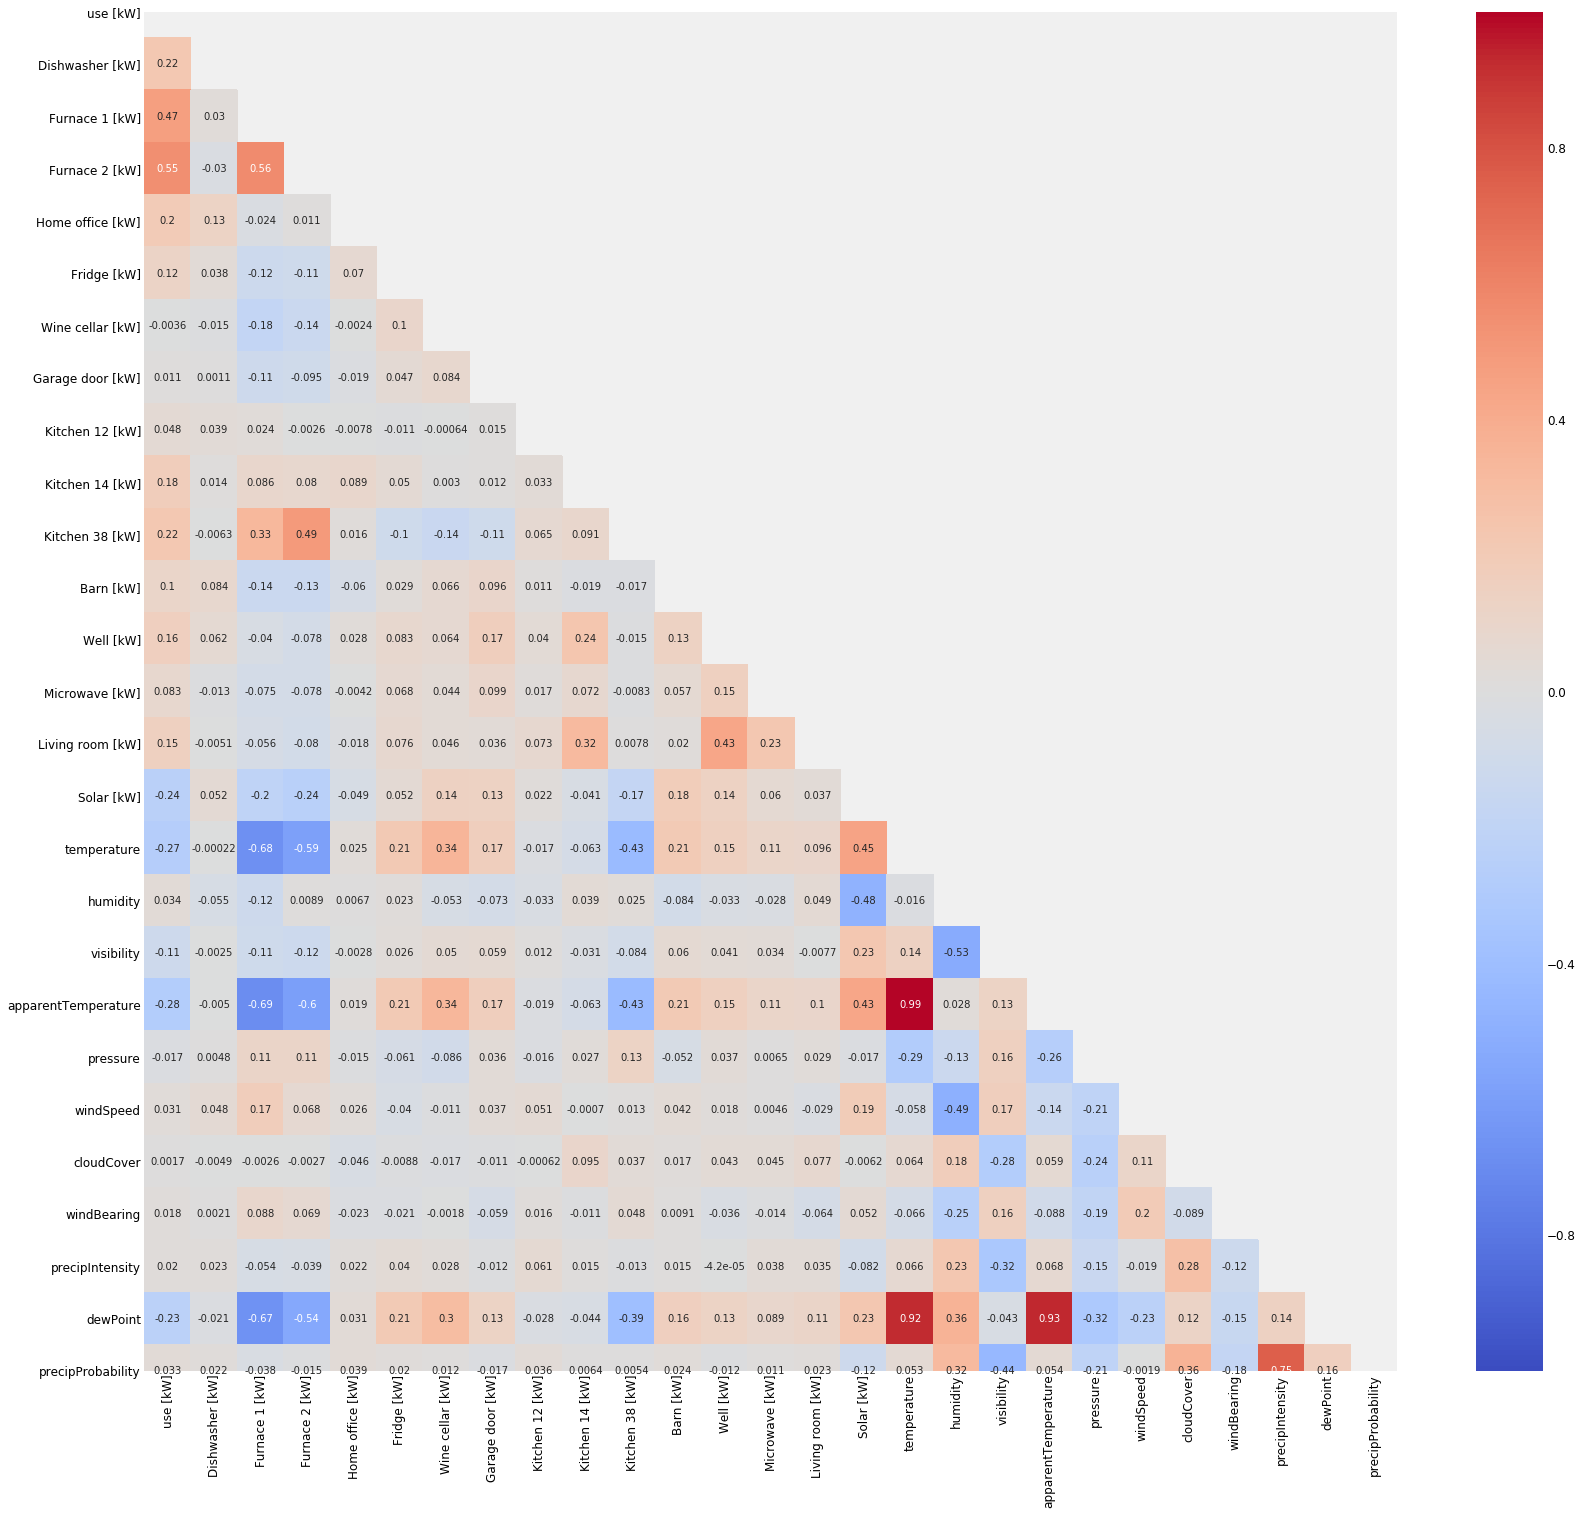

In [36]:
corr = comb_df_hourly.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(25,25))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm', annot=True, mask = mask, vmin=-1)

In [26]:
#dropping apparentTemperature as it almost conveys the same info as temperature. precipProbability has very high correlation
#with precipIntensity and hence dropped
comb_df_hourly = comb_df_hourly.drop(['apparentTemperature', 'precipProbability'], axis=1)
comb_df_hourly['pressure'] = comb_df_hourly['pressure'].apply(np.log)
comb_df_hourly = remove_braces(comb_df_hourly)
comb_df_hourly.shape

(8760, 25)

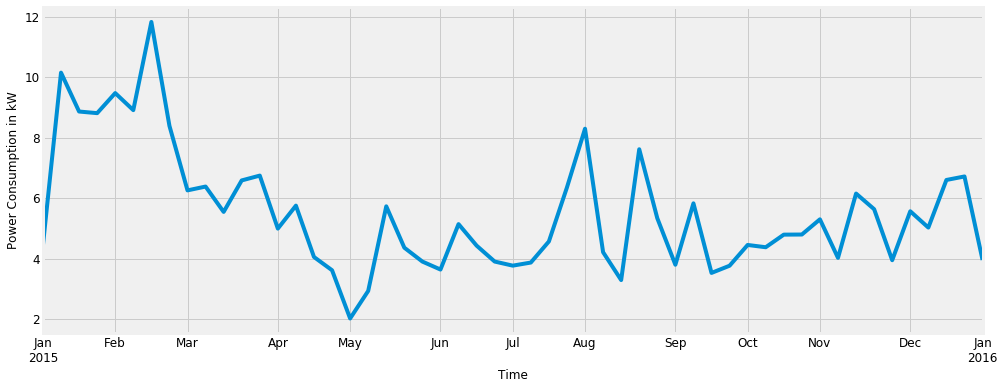

In [38]:
weekly_summary = pd.DataFrame()
weekly_summary['use [kW]'] = comb_df_daily['use _kW_'].resample('W').sum()
ax = weekly_summary['use [kW]'].plot(figsize=(15, 6))
ax.set_xlabel('Time')
ax.set_ylabel('Power Consumption in kW')
plt.show()

**The electricity consumption for House C is as shown above. It is highly irregular trended and we see a sharp rise
in the usage during mid February to March. The consumption is the least in May and the rest of the months in the year show some spikes.**

# Feature Engineering

## Hourly Data
**We add lagged features for weather related data in the dataframe so that our models can learn more from the data. All
weather related features for last 7 samples are added as new features for each sample in the hourly dataframe.**

In [39]:
# Build lagged weather predictors
lagged_df = comb_df_hourly.copy()

# Next hour's load values.
lagged_df['load_hour_after'] = lagged_df['use _kW_'].shift(-1)    

for day in range(8):
    lagged_df['temperature_d' + str(day)] = lagged_df.temperature.shift(day)
    lagged_df['windSpeed_d' + str(day)] = lagged_df.windSpeed.shift(day)
    lagged_df['humidity_d' + str(day)] = lagged_df.humidity.shift(day)
    lagged_df['pressure_d' + str(day)] = lagged_df.pressure.shift(day)
    lagged_df['cloudCover_d' + str(day)] = lagged_df.cloudCover.shift(day)
    lagged_df['windBearing_d' + str(day)] = lagged_df.windBearing.shift(day)
    lagged_df['precipIntensity_d' + str(day)] = lagged_df.precipIntensity.shift(day)
    lagged_df['dewPoint_d' + str(day)] = lagged_df.dewPoint.shift(day)
    lagged_df['load_d' + str(day)] = lagged_df['use _kW_'].shift(day)

     
lagged_df = lagged_df.dropna()
    

lagged_df = lagged_df.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint','use _kW_'])

In [40]:
X = lagged_df.drop(columns=['load_hour_after'])
y = lagged_df['load_hour_after']

In [41]:
X.shape

(6412, 88)

In [42]:
y.shape

(6412,)

# Data Modelling
**We split the data into a time series split with number of slits as 10. This is used to evaluate cross-validation mean absolute errors for models. We also split the data in the ratio of 80:20 for traning and testing respectively. Out of this 80% data, all data points are also used for cross-validation. We train 10 models using this test data and also calculate their corss-validation MAE. We also create our own Blender model that weighs the prediction of each of these models to give a single prediction.**

In [27]:
#Thi baseline model simply takes 80% of data as train data and uses it to predict on remaning training data using data
#of previous 2 samples for each sample in the train set
def baseline_model(series):
    X = series.values
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:]
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # predict
        yhat = history[-2]
        predictions.append(yhat)
        # observation
        obs = test[i]
        history.append(obs)

    # report performance
    mae = mean_absolute_error(test, predictions)
    print('MAE of baseline model: %.3f' % mae)
    return mae

In [158]:
tscv = TimeSeriesSplit(n_splits=10)

def cv_mae(model, X, y):
    mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=tscv)
    return (mae)

def mae(y, y_pred):
    return mean_absolute_error(y, y_pred)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [44]:


print('Building model...')

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=tscv))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=tscv))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=tscv, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

adaboost = AdaBoostRegressor()

extratrees = ExtraTreesRegressor()

bagging = BaggingRegressor()

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm, adaboost, extratrees, bagging),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost,
         'AdaBoost': adaboost,
         'Extratrees': extratrees,
         'Bagging': bagging}
scores = {}

#Evaluating model score
print('Evaluating model cross-validation scores...')
for name, model in models.items():    
    score = cv_mae(model, X_train, y_train)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X_train,y_train)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X_train,y_train)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X_train,y_train)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X_train,y_train)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X_train,y_train)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X_train,y_train)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X_train,y_train)

print('Fitting AdaBoost...')
adaboost_model_full_data = adaboost.fit(X_train,y_train)

print('Fitting extratrees...')
extratrees_model_full_data = extratrees.fit(X_train,y_train)

print('Fitting Bagging...')
bagging_model_full_data = bagging.fit(X_train,y_train)

print('Done fitting all models')

Building model...
Evaluating model cross-validation scores...
Ridge: 0.2377 (0.0531)

Lasso: 0.2364 (0.0542)

ElasticNet: 0.2365 (0.0542)

SVR: 0.2999 (0.0564)

GBR: 0.2710 (0.0650)

LightGBM: 0.2705 (0.0595)

[16:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:51] WARNING: /workspa

In [59]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.045 * elastic_model_full_data.predict(X))+(0.5 * lasso_model_full_data.predict(X))
            +(0.15 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X))
            +(0.15 * gbr_model_full_data.predict(X))+(0.01 * xgb_model_full_data.predict(X))
            +(0.0005 * extratrees_model_full_data.predict(X))
            +(0.005 * bagging_model_full_data.predict(X))
            +(0.001 * lgb_model_full_data.predict(X))+(0.01 * stack_gen_model.predict(np.array(X))))

mae_score = mae(y_train, blend_models_predict(X_train))
print('MAE score on train data:' + str(mae_score))
scores['Blender'] = (mae_score.mean(), mae_score.std())

Blending model predictions...
MAE score on train data:0.18957721545586972


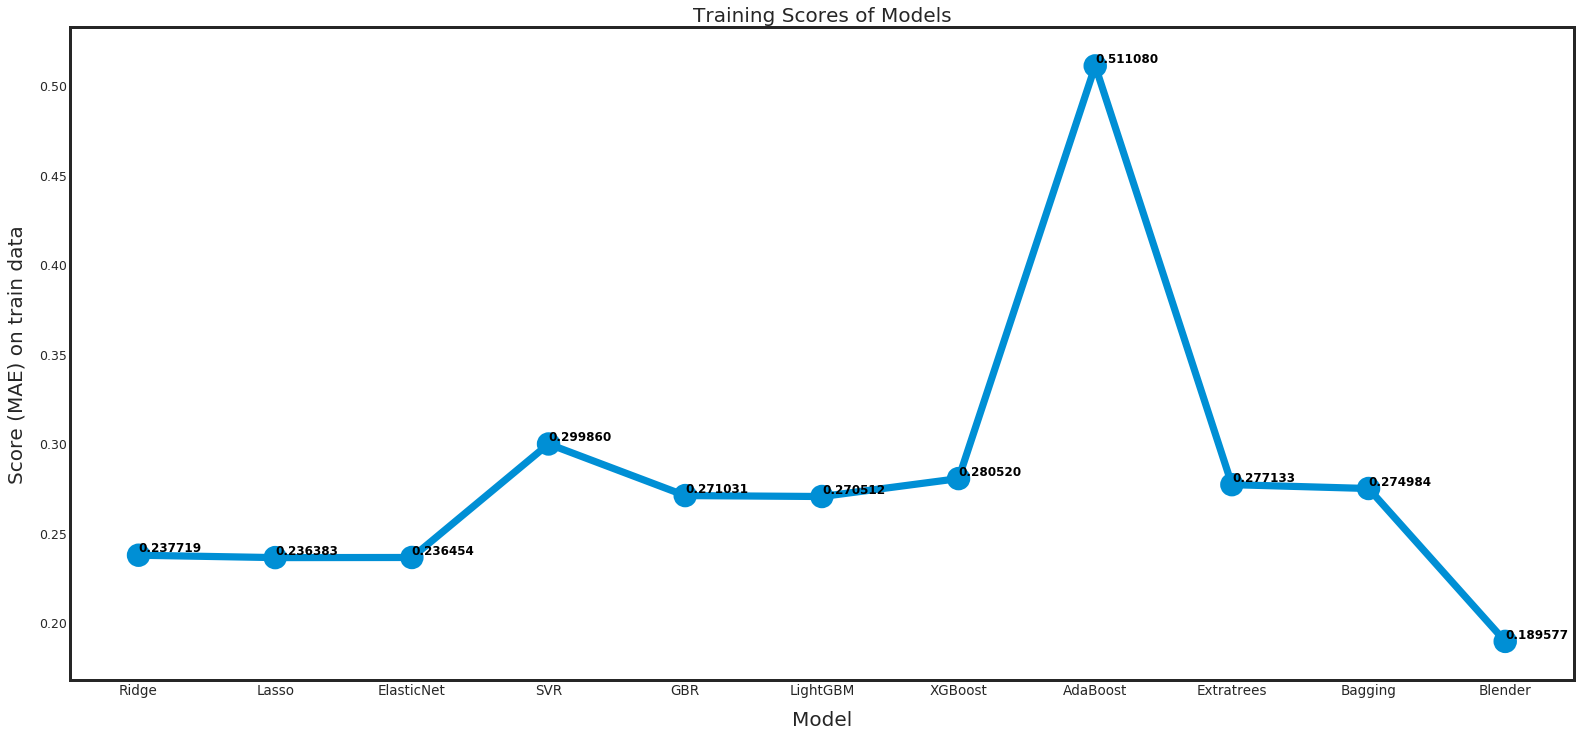

In [60]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on train data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Training Scores of Models', size=20)

plt.show()

**As shown above, Adaboost model has the highest traning MAE of 0.511 while the Blender model has the least MAE of 0.189. All the other models give an MAE between these values with a slight difference in each of them.**

In [61]:
#Store models, scores and prediction values 
test_models = {'Ridge': ridge_model_full_data,
          'Lasso': lasso_model_full_data, 
          'ElasticNet': elastic_model_full_data,
          'SVR': svr_model_full_data,
          'GBR': gbr_model_full_data,
          'LightGBM': lgb_model_full_data,
          'XGBoost': xgb_model_full_data,
         'AdaBoost': adaboost_model_full_data,
         'Extratrees': extratrees_model_full_data,
         'Bagging': bagging_model_full_data}
test_scores = {}

#Evaluating model score
print('Evaluating model test scores...')
for name, model in test_models.items():    
    score = mae( y_test, model.predict(X_test))
    print((name + ": {:.4f} \n").format(score))
    test_scores[name] = score

Evaluating model test scores...
Ridge: 0.2298 

Lasso: 0.2288 

ElasticNet: 0.2288 

SVR: 0.2745 

GBR: 0.2206 

LightGBM: 0.2236 

XGBoost: 0.2185 

AdaBoost: 0.5424 

Extratrees: 0.2438 

Bagging: 0.2487 



MAE score of blender on test data:0.21828152660304784
MAE of baseline model: 0.337


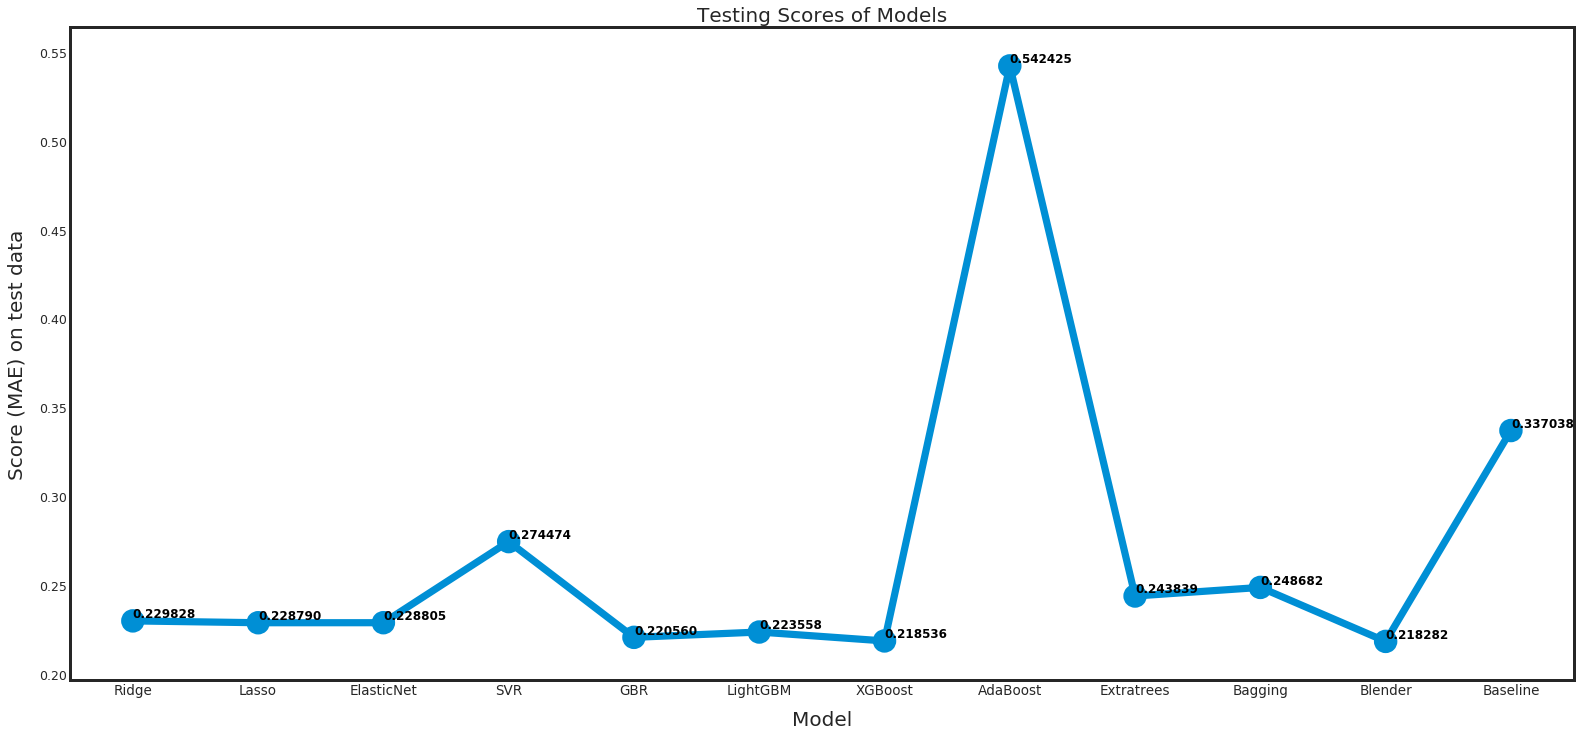

In [62]:
blender_score = mae(y_test, blend_models_predict(X_test))
test_scores['Blender'] = blender_score
print('MAE score of blender on test data:' + str(blender_score))

baseline_score = baseline_model(y)
test_scores['Baseline'] = baseline_score

sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(test_scores.keys()), y=[score for score in test_scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(test_scores.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on test data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Testing Scores of Models', size=20)

plt.show()

**As shown above, similar to the training data, Adaboost model has the highest testing MAE of 0.542 while the Blender model has the least MAE of 0.218. All the other models give an MAE between these values with a slight difference in each of them. Our baseline mode has the MAE of 0.337 which is higher than most of the individual models except AdaBoost. With the help of blender model, we get and MAE better than all the models as well as the baseline model.**

In [63]:
def plot_prediction_multistep(actual, prediction, start_date, title, prediction_label):
    date_rng = pd.date_range(start=start_date, periods=24, freq='H')
    plt.figure(figsize=(30,5))
    plt.title(title)
    plt.plot(actual.index, actual, label='Actual')
    plt.plot(actual.index, prediction, label=prediction_label)
    plt.ylabel('Power(kW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.show()

In [64]:
def get_features(date, comb_df):
    features = comb_df_hourly.loc[date]
    #print(features)
    
    for day in range(8):
        features['temperature_d' + str(day)] = comb_df_hourly.temperature.shift(day)
        features['windSpeed_d' + str(day)] = comb_df_hourly.windSpeed.shift(day)
        features['humidity_d' + str(day)] = comb_df_hourly.humidity.shift(day)
        features['pressure_d' + str(day)] = comb_df_hourly.pressure.shift(day)
        features['cloudCover_d' + str(day)] = comb_df_hourly.cloudCover.shift(day)
        features['windBearing_d' + str(day)] = comb_df_hourly.windBearing.shift(day)
        features['precipIntensity_d' + str(day)] = comb_df_hourly.precipIntensity.shift(day)
        features['dewPoint_d' + str(day)] = comb_df_hourly.dewPoint.shift(day)
        features['load_d' + str(day)] = comb_df_hourly['use _kW_'].shift(day)

    
    features = features.dropna()
    #print(features)
    
    features = features.drop(columns=['temperature', 'windSpeed', 'humidity', 'pressure', 'cloudCover',
                                    'windBearing', 'precipIntensity', 'dewPoint','use _kW_'])

    return features

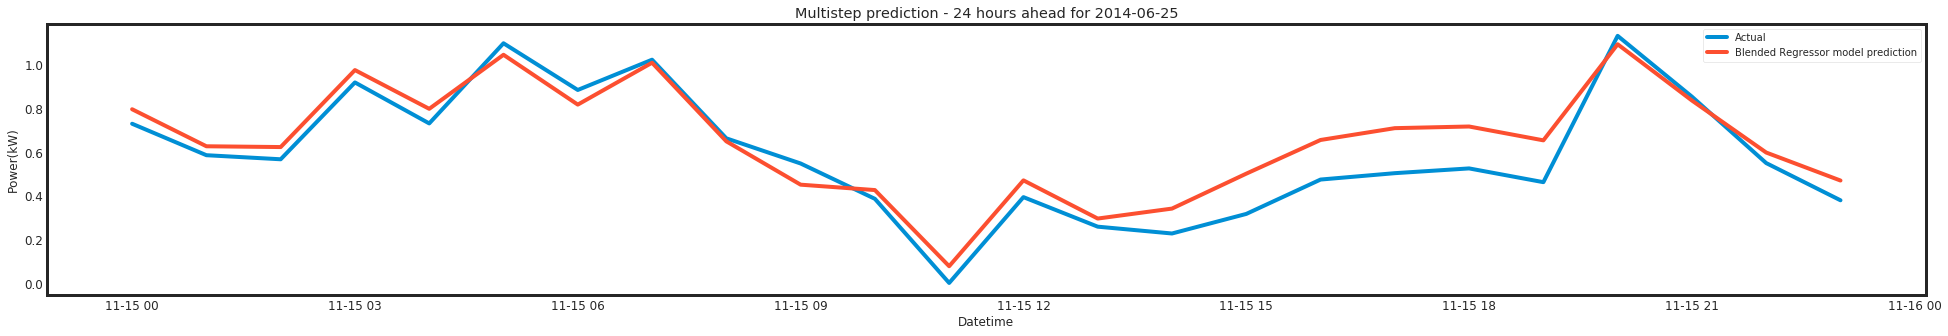

In [67]:
date = '2015-11-15'
prediction = blend_models_predict(get_features(date, comb_df_hourly))
plot_prediction_multistep(actual=comb_df_hourly['use _kW_'].loc[date],prediction=prediction, start_date=date, title='Multistep prediction - 24 hours ahead for 2014-06-25',
                prediction_label='Blended Regressor model prediction') 

**The above graph is a sample prediction of Blender model for hourly electricity consumption on 2015-11-15. The model fits the
actual consuption quite well.**

## Daily Data
**Unlike for the hourly data, we don't add any lagged features for the daily data. Rest of the data split and traning procedure is the same as above.**

In [152]:
X = comb_df_daily.drop(columns = ['use _kW_'])
y = comb_df_daily['use _kW_']

In [153]:
X.shape

(365, 24)

In [154]:
y.shape

(365,)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [159]:
tscv = TimeSeriesSplit(n_splits=10)
print('Building model...')

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=tscv))

lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=tscv))

elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=tscv, l1_ratio=e_l1ratio))  

svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0004,))

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03, max_depth=4, max_features='sqrt', min_samples_leaf=20, min_samples_split=10, loss='huber', random_state =42)                             

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.005, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

xgboost = XGBRegressor(learning_rate=0.01,n_estimators=4060,
                                     max_depth=4, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00005)

adaboost = AdaBoostRegressor()

extratrees = ExtraTreesRegressor()

bagging = BaggingRegressor()

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm, adaboost, extratrees, bagging),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

#Store models, scores and prediction values 
models = {'Ridge': ridge,
          'Lasso': lasso, 
          'ElasticNet': elasticnet,
          'SVR': svr,
          'GBR': gbr,
          'LightGBM': lightgbm,
          'XGBoost': xgboost,
         'AdaBoost': adaboost,
         'Extratrees': extratrees,
         'Bagging': bagging}
scores = {}

#Evaluating model score
print('Evaluating model cross-validation scores...')
for name, model in models.items():    
    score = cv_mae(model, X_train, y_train)
    print((name + ": {:.4f} ({:.4f})\n").format(score.mean(), score.std()))
    scores[name] = (score.mean(), score.std())
    
print('Done evaluating')

print('Fitting models...')

print('Fitting StackingRegressor...')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

print('Fitting ElasticNet...')
elastic_model_full_data = elasticnet.fit(X_train,y_train)

print('Fitting Lasso...')
lasso_model_full_data = lasso.fit(X_train,y_train)

print('Fitting Ridge...')
ridge_model_full_data = ridge.fit(X_train,y_train)

print('Fitting SVR...')
svr_model_full_data = svr.fit(X_train,y_train)

print('Fitting GradientBoosting...')
gbr_model_full_data = gbr.fit(X_train,y_train)

print('Fitting XGBoost...')
xgb_model_full_data = xgboost.fit(X_train,y_train)

print('Fitting LightGBM...')
lgb_model_full_data = lightgbm.fit(X_train,y_train)

print('Fitting AdaBoost...')
adaboost_model_full_data = adaboost.fit(X_train,y_train)

print('Fitting extratrees...')
extratrees_model_full_data = extratrees.fit(X_train,y_train)

print('Fitting Bagging...')
bagging_model_full_data = bagging.fit(X_train,y_train)

print('Done fitting all models')

Building model...
Evaluating model cross-validation scores...
Ridge: 0.1774 (0.0598)

Lasso: 0.1741 (0.0659)

ElasticNet: 0.1744 (0.0661)

SVR: 0.1691 (0.0612)

GBR: 0.1904 (0.0870)

LightGBM: 0.2146 (0.0833)

[21:47:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:47:29] WARNING: /workspa

In [168]:
#Blending model predictions
print('Blending model predictions...')
def blend_models_predict(X):
    return ((0.15 * adaboost_model_full_data.predict(X))
            +(0.05 * ridge_model_full_data.predict(X)) + (0.1 * svr_model_full_data.predict(X))
            +(0.15 * gbr_model_full_data.predict(X))+(0.1 * xgb_model_full_data.predict(X))
            +(0.015 * extratrees_model_full_data.predict(X))
            +(0.005 * bagging_model_full_data.predict(X))
            +(0.01 * lgb_model_full_data.predict(X))+(0.4 * stack_gen_model.predict(np.array(X))))

mae_score = mae(y_train, blend_models_predict(X_train))
print('MAE score on train data:' + str(mae_score))
scores['Blender'] = (mae_score.mean(), mae_score.std())

Blending model predictions...
MAE score on train data:0.0360109207774867


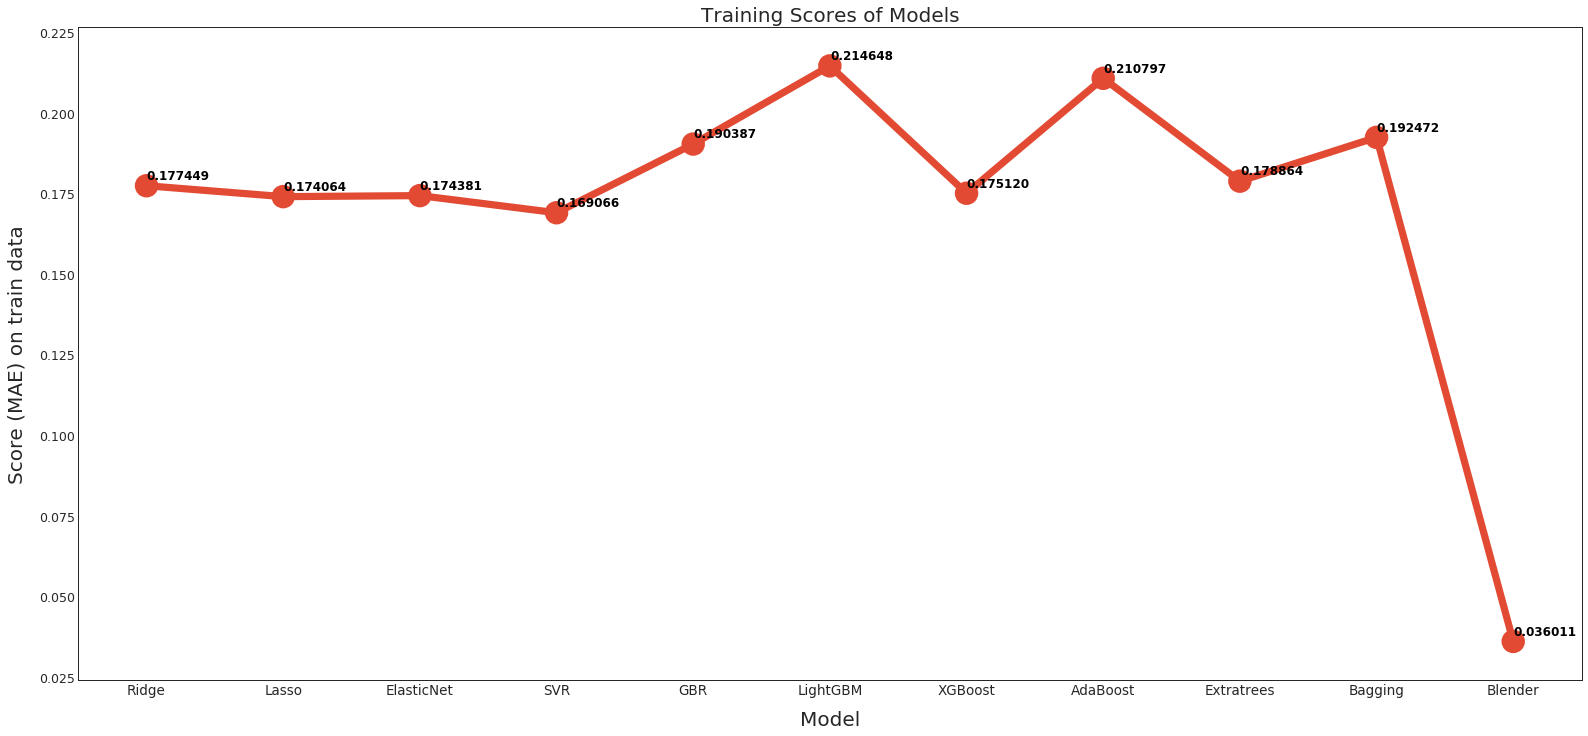

In [169]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on train data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Training Scores of Models', size=20)

plt.show()

**As shown above, LightGBM and AdaBoost models have the highest traning MAE of 0.21 while the Blender model has the least MAE of 0.036. All the other models give an MAE which is lower than Lasso and ElasticNet but Blender model beats them all.**

In [170]:
#Store models, scores and prediction values 
test_models = {'Ridge': ridge_model_full_data,
          'Lasso': lasso_model_full_data, 
          'ElasticNet': elastic_model_full_data,
          'SVR': svr_model_full_data,
          'GBR': gbr_model_full_data,
          'LightGBM': lgb_model_full_data,
          'XGBoost': xgb_model_full_data,
         'AdaBoost': adaboost_model_full_data,
         'Extratrees': extratrees_model_full_data,
         'Bagging': bagging_model_full_data}
test_scores = {}

#Evaluating model score
print('Evaluating model test scores...')
for name, model in test_models.items():    
    score = mae( y_test, model.predict(X_test))
    print((name + ": {:.4f} \n").format(score))
    test_scores[name] = score

Evaluating model test scores...
Ridge: 0.0976 

Lasso: 0.1196 

ElasticNet: 0.1200 

SVR: 0.1090 

GBR: 0.0927 

LightGBM: 0.0951 

XGBoost: 0.0965 

AdaBoost: 0.1718 

Extratrees: 0.1134 

Bagging: 0.1382 



In [171]:
blender_score = mae(y_test, blend_models_predict(X_test))
test_scores['Blender'] = blender_score
print('MAE score of blender on test data:' + str(blender_score))

baseline_score = baseline_model(y)
test_scores['Baseline'] = baseline_score

MAE score of blender on test data:0.09433229706603018
MAE of baseline model: 0.221


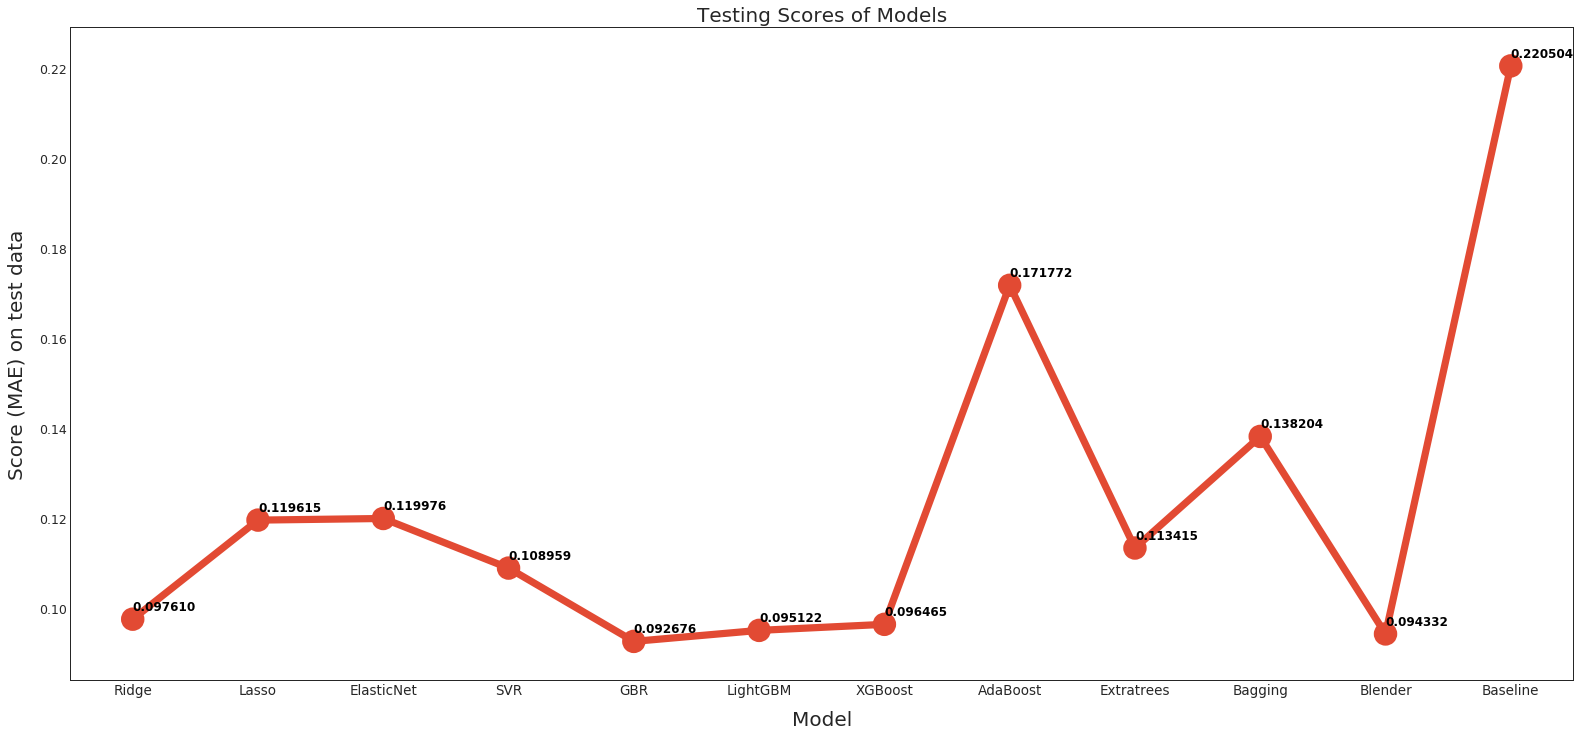

In [172]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(test_scores.keys()), y=[score for score in test_scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(test_scores.values()):
    ax.text(i, score + 0.002, '{:.6f}'.format(score), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (MAE) on test data', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Testing Scores of Models', size=20)

plt.show()

**As shown above, similar to the training data, AdaBoost model has the highest testing MAE of 0.17 while the GBR model has least MAE of 0.092 which is slightly better than Blender model which has the MAE of 0.22. All the other models give an MAE between these values with a slight difference in each of them. Our baseline mode has the MAE of 0.133 which is higher than all. Since we got the least training MAE with blender model, we predict daily consumption With the help of blender model.**

In [165]:
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)

    axes[0].set_title('Actual vs Prediction - One week')
    axes[0].set_ylabel('Power(kW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=actual.index[-7] , right=actual.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One month')
    axes[1].set_ylabel('Power(kW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()

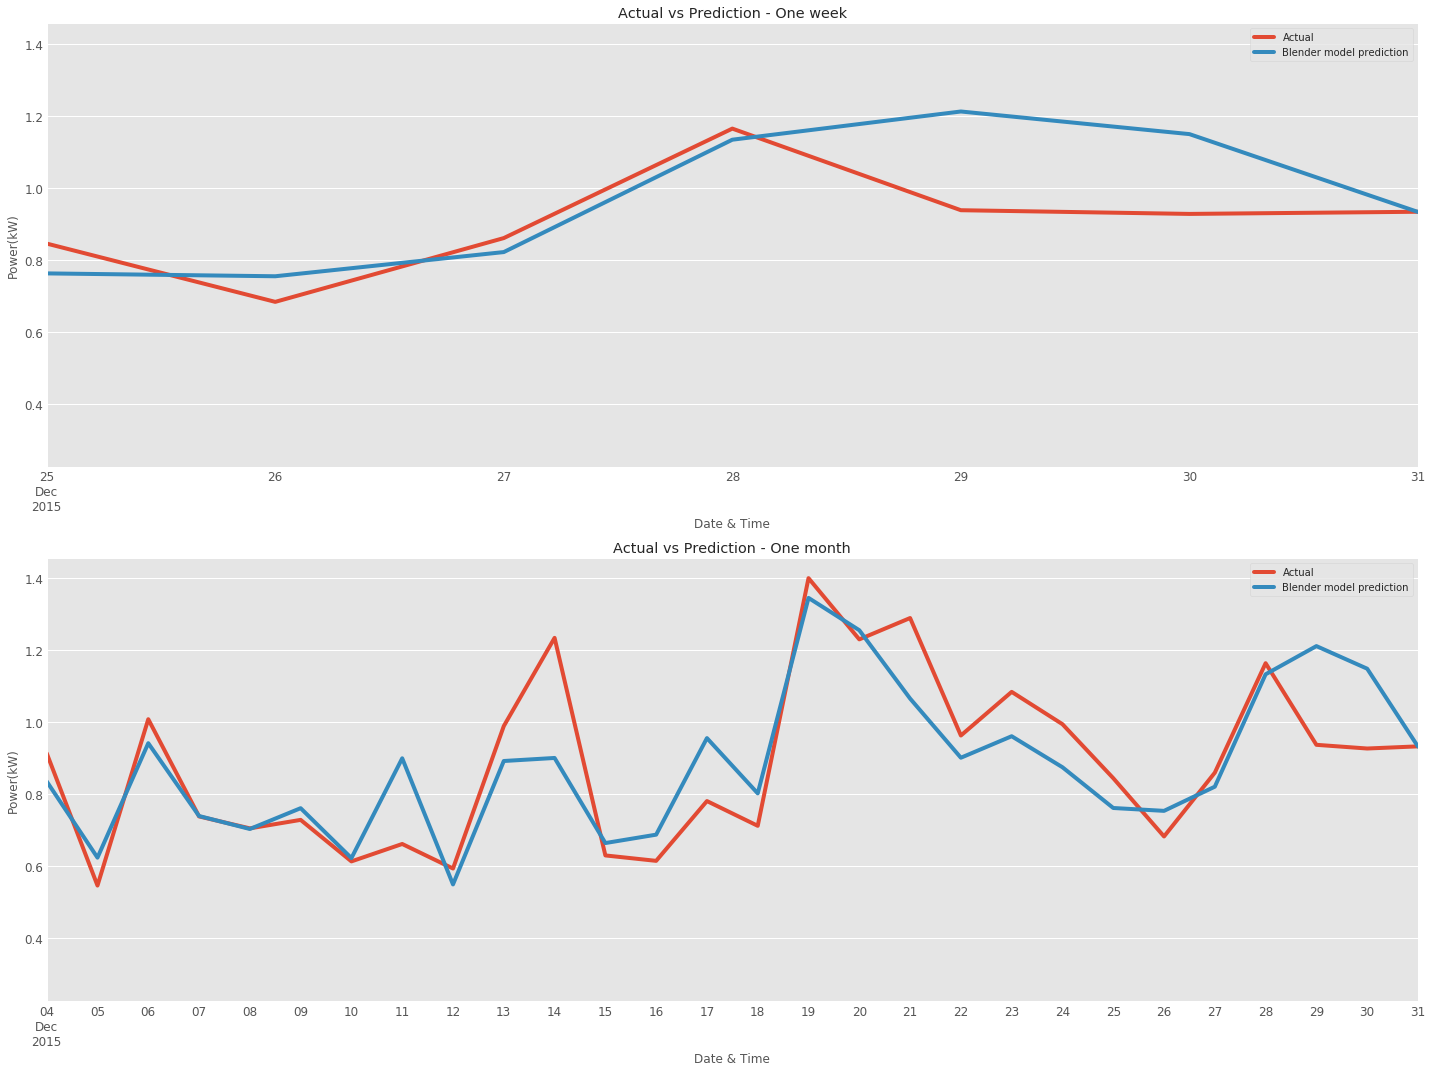

In [173]:
plt.style.use('ggplot')
subplot_prediction(y_test, blend_models_predict(X_test),prediction_label='Blender model prediction')

**Above are the daily prediction plots for an entire last week of December for our blender model. The model seems to fit the actual consumption decently. Same is the case with the predictions of the model over the entire month of December.**

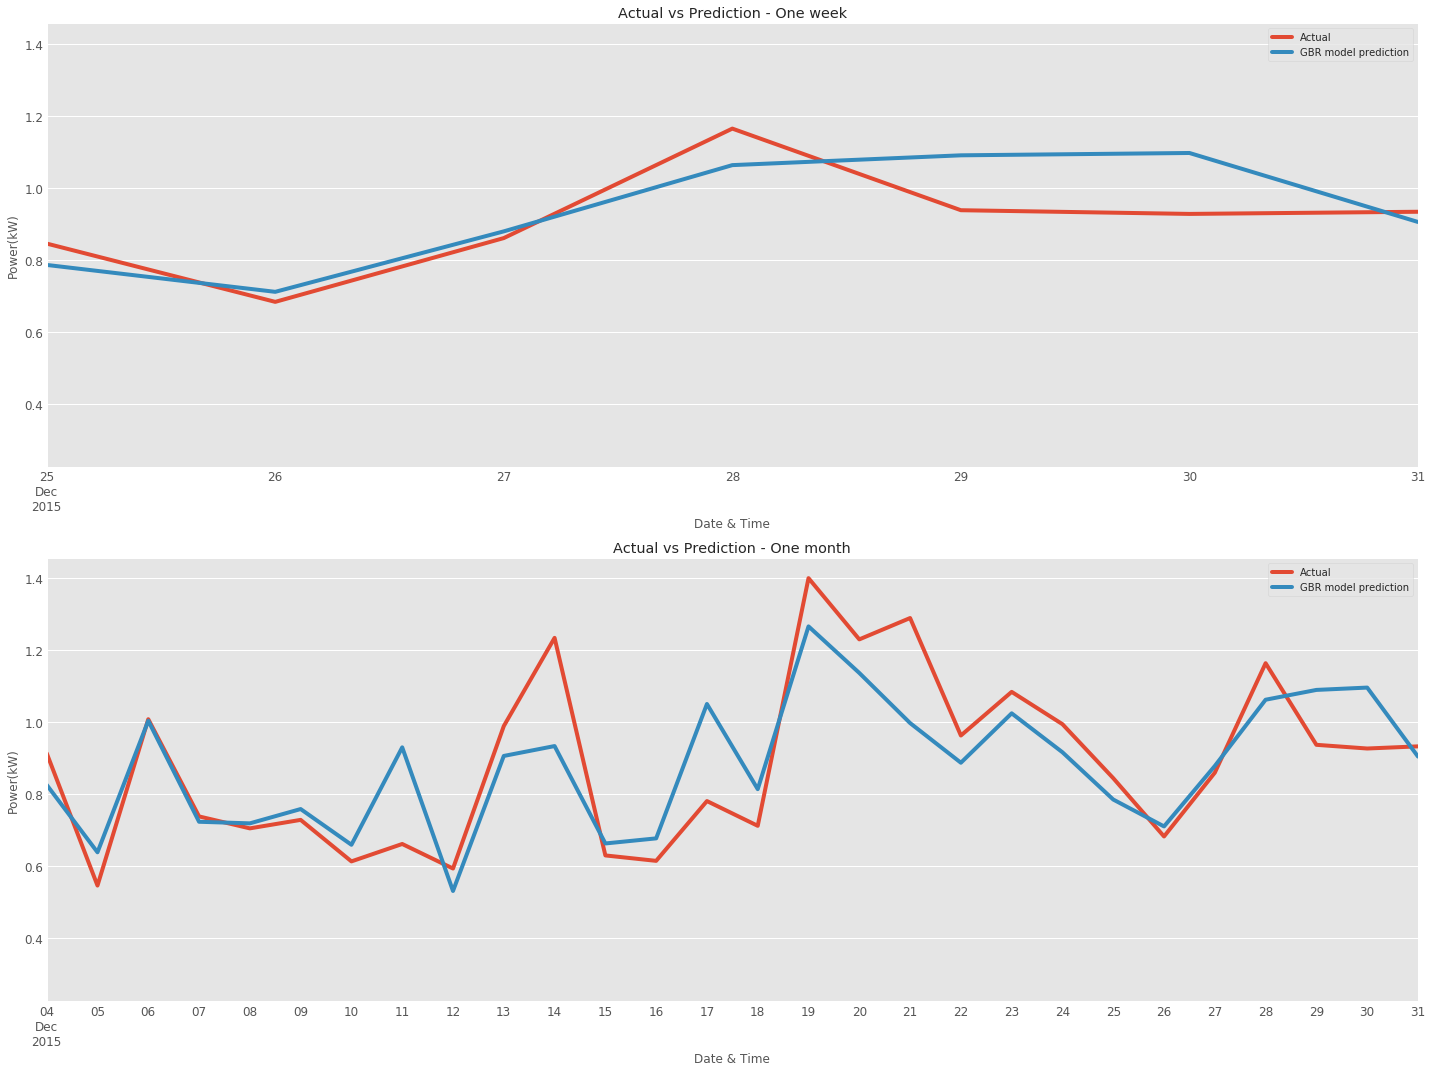

In [175]:
subplot_prediction(y_test, gbr_model_full_data.predict(X_test),prediction_label='GBR model prediction')

**Above are the daily prediction plots for an entire last week of December for GBR model. The model seems to fit the actual consumption slightly better than Blender model. Same is the case with the predictions of the model over the entire month of December.**